In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pytz
from typing import Callable, List, Dict, Tuple

In [10]:
def download_smard_data(target_date: str, output_dir: str):
    """
    Downloads day-ahead price data for a specified date from the SMARD.de website
    and retrieves the 24-hour data for that specific day.
    Args:
    target_date (str): Date in the format 'YYYY-MM-DD'.
    output_dir (str): Directory to save the downloaded CSV file.
    """
    # Define timezone
    local_timezone = pytz.timezone("Europe/Berlin")
    # Parse the target date
    date_string = f"{target_date} 00:00:00"
    local_date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")
    localized_date_object = local_timezone.localize(local_date_object)
    epoch_timestamp = int(local_date_object.timestamp())
    # Calculate the offset based on the weekday (0 = Monday, 6 = Sunday)
    weekday = localized_date_object.weekday() # Monday = 0, Sunday = 6
    hour_offset = weekday * 24
    timestamp_in_milliseconds = epoch_timestamp * 1000 - (hour_offset * 3600 * 1000)
    # Fetch data from the SMARD.de API (returns 168 hours of data starting from the time
    url = f"https://www.smard.de/app/chart_data/4169/DE/4169_DE_hour_{timestamp_in_milliseconds}.json"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code}")
        return
    data = response.json()
    if "series" not in data or not data["series"]:
        print("No data available for the specified date.")
        return
    series = data["series"]
    # Extract the 24-hour data for the given date
    start_index = hour_offset
    end_index = hour_offset + 24
    day_series = series[start_index:end_index]
    observed_prices = [item[1] for item in day_series]
    print(f"Data Series for {target_date}: {day_series}")
    print(f"Hourly Prices for {target_date}: {observed_prices}")
    # Prepare the data as a DataFrame
    df = pd.DataFrame({
    "Hour": list(range(1, 25)),
    "Germany/Luxembourg in €/MWh": observed_prices
    })
    # Create the output directory structure
    date_dir = os.path.join(output_dir, target_date)
    os.makedirs(date_dir, exist_ok=True)
    # Save the CSV file
    output_file = os.path.join(date_dir, "actual_values.csv")
    df.to_csv(output_file, index=False)
    print(f"Data saved to: {output_file}")

def generate_sample_predictions(actual_values_filename: str, output_dir: str):
    """
    Generates sample prediction files that deviate from the actual values.
    Args:
    actual_values_path (str): Path to the actual values CSV file.
    output_dir (str): Directory to save the generated prediction files.
    Example:
    generate_sample_predictions('actual_values.csv', './data/2024-03-18')
    """
    # Load the actual values
    actual_values_path = os.path.join(output_dir, actual_values_filename)
    actual_values_df = pd.read_csv(actual_values_path)
    actual_values = actual_values_df["Germany/Luxembourg in €/MWh"].tolist()
    # Generate deviating predictions
    predictions = {
    "prediction_1.csv": [v * 1.1 for v in actual_values], # 10% higher
    "prediction_2.csv": [v * 0.9 for v in actual_values], # 10% lower
    "prediction_3.csv": [v + np.random.uniform(-50, 50) for v in actual_values], #
    "prediction_4.csv": [v if i % 2 == 0 else v * 1.2 
                         for i, v in enumerate(actual_values)]
    }
    # Save the generated predictions as CSV files
    os.makedirs(output_dir, exist_ok=True)
    for filename, prediction in predictions.items():
        prediction_df = pd.DataFrame({
            "Hour": list(range(1, 25)),
            "Germany/Luxembourg in €/MWh": prediction
        })
        output_path = os.path.join(output_dir, filename)
        prediction_df.to_csv(output_path, index=False)
        print(f"Prediction saved to: {output_path}")

In [11]:
# Evaluation metric functions
EVALUATION_METRICS: List[Tuple[str, Callable[[List[float], List[float]], float]]] = [
    ("MAE", lambda target, pred: sum(abs(t - p) for t, p in zip(target, pred)) / len(target)),
    ("MSE", lambda target, pred: sum((t - p) ** 2 for t, p in zip(target, pred)) / len(target)),
    ("RMSE", lambda target, pred: (sum((t - p) ** 2 for t, p in zip(target, pred)) / len(target))),
    ("MAPE", lambda target, pred: sum(abs((t - p) / t) for t, p in zip(target, pred) if t != 0)/ sum(1 for t in target if t != 0)* 100)]
# Function to evaluate predictions
def evaluate_predictions_from_directory(output_dir: str, actual_values_filename: str = "actual_values.csv"):
    """
    Evaluates and ranks prediction files in a directory against the actual values file.
    Args:
    output_dir (str): Directory containing the actual values file and prediction fil
    actual_values_filename (str): Name of the actual values file (default is "actual_
    Returns:
    pd.DataFrame: Ranking of prediction files with their scores for each function.
    """
    # Locate the actual values file
    actual_values_path = os.path.join(output_dir, actual_values_filename)
    if not os.path.exists(actual_values_path):
        raise FileNotFoundError(f"Actual values file not found at {actual_values_path}")
    # Load the actual values
    actual_df = pd.read_csv(actual_values_path)
    actual_values = actual_df["Germany/Luxembourg in €/MWh"].tolist()
    # Find all prediction files in the directory
    prediction_files = [
        os.path.join(output_dir, f) for f in os.listdir(output_dir)
        if f.endswith(".csv") and f != actual_values_filename
    ]
    results = []
    for file in prediction_files:
        # Load the prediction data
        prediction_df = pd.read_csv(file)
        prediction_values = prediction_df["Germany/Luxembourg in €/MWh"].tolist()
        # Compute scores for all functions
        scores = {name: func(actual_values, prediction_values) for name, func in EVALUATION_METRICS}
        results.append({"File": os.path.basename(file), **scores})
    # Create a DataFrame for scores and ranks separately
    rankings_df = pd.DataFrame(results)
    # Create scores DataFrame
    scores_df = rankings_df[["File"] + [metric[0] for metric in EVALUATION_METRICS]]
    # Add ranking columns for each metric
    for name in [metric[0] for metric in EVALUATION_METRICS]:
        rankings_df[f"Rank_{name}"] = rankings_df[name].rank(ascending=True)
    # Compute total ranking position
    rank_cols = [col for col in rankings_df.columns if col.startswith("Rank_")]
    rankings_df["Average_Rank"] = rankings_df[rank_cols].mean(axis=1)
    # Create ranks DataFrame
    ranks_df = rankings_df[["File", "Average_Rank"] + rank_cols]
    ranks_df = ranks_df.sort_values(by="Average_Rank")
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.step(range(1, 25), actual_values, label="Actual Values", 
         linewidth=3, color="black")
    for file in prediction_files:
        prediction_df = pd.read_csv(file)
        prediction_values = prediction_df["Germany/Luxembourg in €/MWh"].tolist()
    # plt.step(range(1, 25), prediction_values, label=os.path.basename(file), alpha=
    plt.fill_between(
    range(1, 25), prediction_values, actual_values,
    step="post", alpha=0.2, label=f"Error: {os.path.basename(file)}"
    )
    plt.xlabel("Hour")
    plt.ylabel("Energy Price (€/MWh)")
    plt.title("Comparison of Actual Values and Predictions")
    plt.legend()
    plt.show()
    return scores_df, ranks_df

Data Series for 2024-02-18: [[1708210800000, 62.38], [1708214400000, 54.81], [1708218000000, 51.44], [1708221600000, 50.32], [1708225200000, 50.19], [1708228800000, 48.47], [1708232400000, 46.02], [1708236000000, 48.97], [1708239600000, 47.28], [1708243200000, 43.03], [1708246800000, 40.45], [1708250400000, 41.0], [1708254000000, 40.1], [1708257600000, 39.88], [1708261200000, 42.87], [1708264800000, 54.29], [1708268400000, 62.87], [1708272000000, 72.0], [1708275600000, 73.66], [1708279200000, 70.59], [1708282800000, 64.71], [1708286400000, 59.83], [1708290000000, 57.33], [1708293600000, 53.94]]
Hourly Prices for 2024-02-18: [62.38, 54.81, 51.44, 50.32, 50.19, 48.47, 46.02, 48.97, 47.28, 43.03, 40.45, 41.0, 40.1, 39.88, 42.87, 54.29, 62.87, 72.0, 73.66, 70.59, 64.71, 59.83, 57.33, 53.94]
Data saved to: data_science_challenge/data/2024-02-18/actual_values.csv
Prediction saved to: data_science_challenge/data/2024-02-18/prediction_1.csv
Prediction saved to: data_science_challenge/data/2024

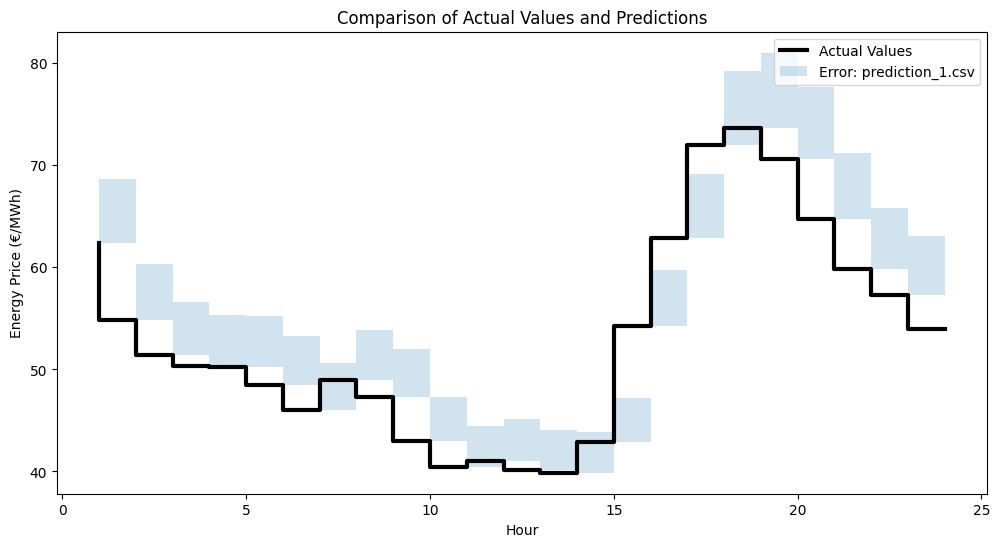

Scores:
            File       MAE          MSE         RMSE       MAPE
  prediction.csv 97.844350 10826.785029 10826.785029 191.327144
prediction_4.csv  5.309417    58.350234    58.350234  10.000000
prediction_3.csv 22.844146   733.459963   733.459963  43.455677
prediction_2.csv  5.318458    29.314312    29.314312  10.000000
prediction_1.csv  5.318458    29.314312    29.314312  10.000000

Ranks:
            File  Average_Rank  Rank_MAE  Rank_MSE  Rank_RMSE  Rank_MAPE
prediction_2.csv           1.5       2.0       1.0        1.0        2.0
prediction_4.csv           2.0       1.0       3.0        3.0        1.0
prediction_1.csv           2.5       3.0       2.0        2.0        3.0
prediction_3.csv           4.0       4.0       4.0        4.0        4.0
  prediction.csv           5.0       5.0       5.0        5.0        5.0


In [12]:
# Example Usage
data_directory = os.path.join('data_science_challenge', 'data')
exampleDate = '2024-02-18'
exampleDate_directory = os.path.join(data_directory, exampleDate)
download_smard_data(exampleDate, data_directory) # downloads the actual values for a giv
generate_sample_predictions('actual_values.csv', exampleDate_directory) # generate sampl
scores, ranks = evaluate_predictions_from_directory(
output_dir=os.path.join(data_directory, exampleDate)
)
# Print scores and ranks without index
print("Scores:")
print(scores.to_string(index=False))
print("\nRanks:")
print(ranks.to_string(index=False))